<a href="https://colab.research.google.com/github/Paul-mwaura/AI-in-Medicine/blob/main/MRI_Segmentation_%26_Classification_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Detection and Localization - UNET

## Understanding The Problem

### Download the Dataset

In [1]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"paulmwaura","key":"7fc33bc18ae8d8af92733cc834498b7a"}'}

In [2]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# Next, install the Kaggle API client.
!pip install -q kaggle

-rw-r--r-- 1 root root 66 May 30 10:48 kaggle.json


In [3]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 98% 701M/714M [00:04<00:00, 163MB/s]
100% 714M/714M [00:04<00:00, 157MB/s]


### Import Libraries

In [5]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model ,Sequential
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D
from tensorflow.keras.layers import MaxPooling2D, concatenate, Dense, Flatten ,UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
%%capture
!unzip lgg-mri-segmentation.zip -d lgg-mri-segmentation

### Read path of image

In [7]:
# Set parameters
Size = (256, 256)
mask_files = glob('../content/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
train_files = [file.replace('_mask', '') for file in mask_files]

show 5 path of image

In [8]:
mask_files[:5]

['../content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_1_mask.tif',
 '../content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_15_mask.tif',
 '../content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_17_mask.tif',
 '../content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_14_mask.tif',
 '../content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_7_mask.tif']

Show 5 path of mask

In [9]:
train_files[:5]

['../content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_1.tif',
 '../content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_15.tif',
 '../content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_17.tif',
 '../content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_14.tif',
 '../content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_7.tif']

DataFrame of path image & mask & label

In [10]:
def label(mask):
    value = np.max(cv2.imread(mask))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image": train_files,
                   "mask": mask_files,
                  "label":[label(x) for x in mask_files]})

Show 5 rows

In [11]:
df.head()

,image,mask,label
0,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,0
1,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,1
2,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,1
3,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,1
4,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,../content/lgg-mri-segmentation/kaggle_3m/TCGA...,0


show Length of each class

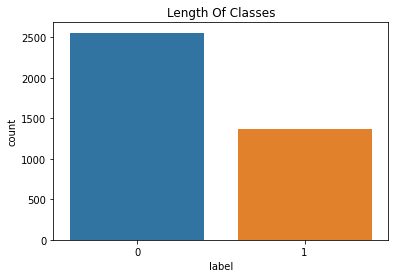

In [12]:
sns.countplot(data=df,x=df['label'])
plt.title('Length Of Classes')
plt.show()

Take 5 row of each class

In [13]:
df_Tumor = df[df['label']=='1'].sample(5).values
df_NotTumor = df[df['label']=='0'].sample(5).values

Show row of Tumor

In [14]:
df_Tumor[0]

array(['../content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_37.tif',
       '../content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_37_mask.tif',
       '1'], dtype=object)

Show row of Not Tumor

In [15]:
df_NotTumor[0]

array(['../content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_11.tif',
       '../content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_11_mask.tif',
       '0'], dtype=object)

### Show image and Mask of each Class

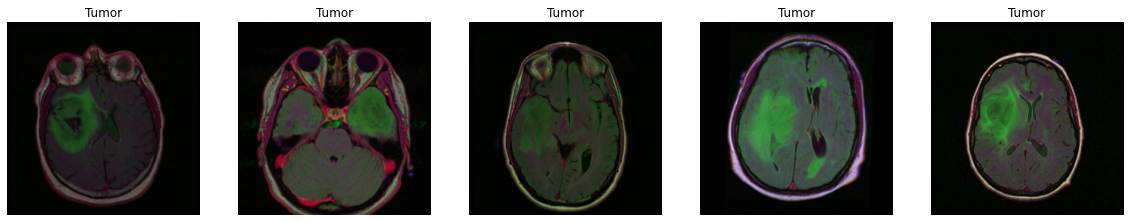

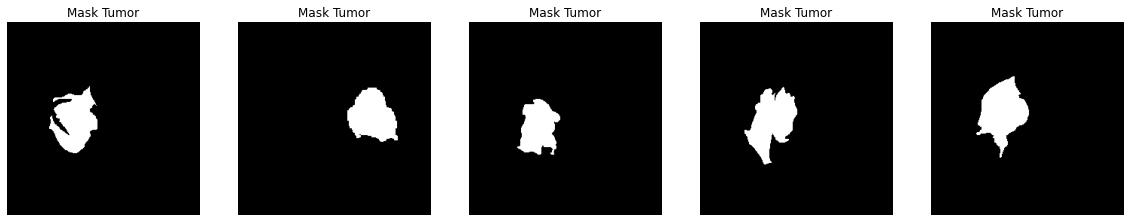

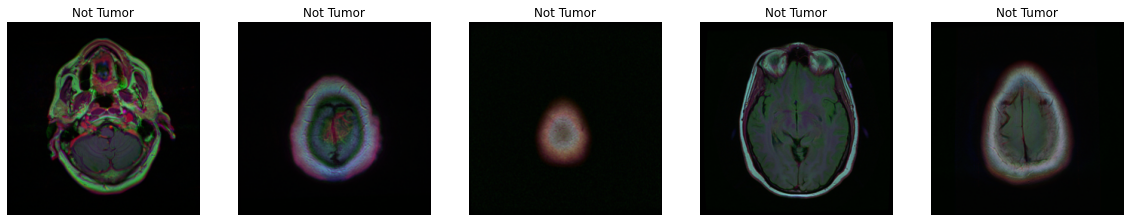

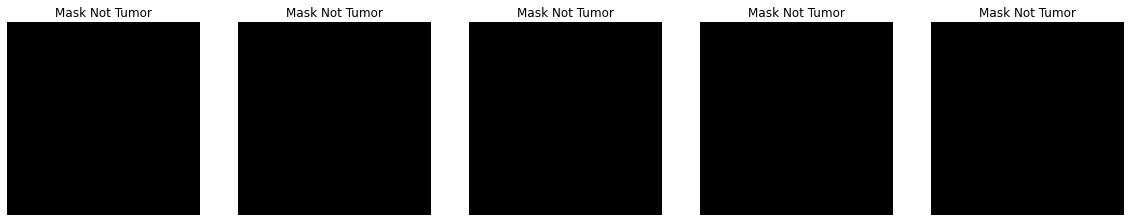

In [16]:
#showing training images with labels
plt.figure(figsize=(20,20))
plt.title('Tumor')
for n , i in enumerate(range(5)) : 
    plt.subplot(1,5,n+1)
    img=cv2.imread(df_Tumor[i,0])
    plt.title('Tumor')
    plt.imshow(img)
    plt.axis('off')
    #showing training images with labels
plt.show()
plt.figure(figsize=(20,20))
for n , i in enumerate(range(5)) :
    plt.subplot(1,5,n+1)
    plt.title('Mask Tumor')
    img=cv2.imread(df_Tumor[i,1])
    plt.imshow(img)
    
    plt.axis('off')
plt.show()

#showing training images with labels
plt.figure(figsize=(20,20))
plt.title('Tumor')
for n , i in enumerate(range(5)) : 
    plt.subplot(1,5,n+1)
    plt.title('Not Tumor')
    img=cv2.imread(df_NotTumor[i,0])
    plt.imshow(img)
    plt.axis('off')
    #showing training images with labels
plt.show()
plt.figure(figsize=(20,20))
for n , i in enumerate(range(5)) :
    plt.subplot(1,5,n+1)
    plt.title('Mask Not Tumor')
    img=cv2.imread(df_NotTumor[i,1])
    plt.imshow(img)
    
    plt.axis('off')
plt.show()

### Split data train (0.9) valid (0.5) test (0.05)

In [17]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1)
df_test, df_val = train_test_split(df_test, test_size=0.5)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(3536, 3)
(197, 3)
(196, 3)


## Data Preparation

### Augmentation and Scalling

In [18]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

## Segmentation Model

### Unet architecture
>>
<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse2.mm.bing.net%2Fth%3Fid%3DOIP.lvXoKMHoPJMKpKK7keZMEAHaE7%26pid%3DApi&f=1">Unet</img>

In [19]:
def unet(input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs= inputs, outputs = conv10)
    return model

In [20]:
m=unet()
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

<img src="https://storage.googleapis.com/kaggle-media/competitions/rsna/IoU.jpg"></img>

In [21]:
smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

#### Training Parameters

In [22]:
# Set parameters
EPOCHS = 15
BATCH_SIZE = 16
learning_rate = 1e-3

#### Read Data and augmentation

In [23]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=Size)
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=Size)

#### Create Model Unet

In [24]:
model = unet(input_size=(Size[0], Size[1], 3))

Optimization and CallBacks

In [25]:
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

callbacks = [ModelCheckpoint('brainMRI_Segment.hdf5', verbose=0, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
            EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15)]

Compile model

In [26]:
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[iou, dice_coef])

Fitting Model

In [ ]:
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) // BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps=len(df_val) // BATCH_SIZE)

Found 3536 validated image filenames.
Found 3536 validated image filenames.
Epoch 1/15
 12/221 [>.............................] - ETA: 6:20:42 - loss: 4.1320 - iou: 0.0035 - dice_coef: 0.0070

#### visualization Accuracy and Loss

In [ ]:
plt.figure(figsize=(8,15))
plt.subplot(3,1,1)
plt.plot(model.history.history['loss'], 'b-', label='train_loss')
plt.plot(model.history.history['val_loss'], 'r-', label='val_loss')
plt.legend(loc='best')
plt.title('Loss')

plt.subplot(3,1,2)
plt.plot(model.history.history['iou'], 'b-', label='train_iou')
plt.plot(model.history.history['val_iou'], 'r-', label='val_iou')
plt.legend(loc='best')
plt.title('IoU')

plt.subplot(3,1,3)
plt.plot(model.history.history['dice_coef'], 'b-', label='train_dice_coef')
plt.plot(model.history.history['val_dice_coef'], 'r-', label='val_dice_coef')
plt.legend(loc='best')
plt.title('Dice Coef')

#### Prediction

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=Size)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

visualization The prediction

In [ ]:
for i in range(10):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image'].iloc[index])
    img = cv2.resize(img ,Size)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

## Classification Model

#### Read Data and augmentation

Train Data

In [ ]:
Gen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            rotation_range=0.1,
            width_shift_range=0.05,
            height_shift_range=0.05,
            shear_range=0.05,
            zoom_range=0.05,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
)

In [ ]:
len(df[df['label']=='1'])

In [ ]:
d1=np.array(df[df['label']=='0'].sample(1373).values)
d2=np.array(df[df['label']=='1'].sample(1373).values)

In [ ]:
ddd=np.vstack([d1,d2])

In [ ]:
df_train=pd.DataFrame(ddd,columns=['image','mask','label'])

In [ ]:
df_train.shape

In [ ]:
train= Gen.flow_from_dataframe(
            dataframe=df_train,
            x_col="image",
            y_col="label",
            has_ext=False,
            batch_size=16,
            seed=42,
            shuffle=True,
            color_mode='rgb',
            class_mode="binary",
            target_size=Size
)
print('Train generator created')

In [ ]:
plt.title('train data count')
sns.countplot(train.classes)
plt.show()

In [ ]:
classes={0:'Not Tumor',1:'Tumor'}
plt.figure(figsize=(20,20))
for X_batch, y_batch in train:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[y_batch[i]])
    # show the plot
    plt.show()
    break

Validation Data

In [ ]:
Genn = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            )
valid = Genn.flow_from_dataframe(
            dataframe=df_val,
            x_col="image",
            y_col="label",
            has_ext=False,
            batch_size=16,
            seed=42,
            shuffle=True,
            color_mode='rgb',#rgb 
            class_mode="binary",
            target_size=Size
)
print('Valid generator created')

In [ ]:
plt.title('valid data count')
sns.countplot(valid.classes)
plt.show()

In [ ]:
classes={0:'Not Tumor',1:'Tumor'}
plt.figure(figsize=(20,20))
for X_batch, y_batch in valid:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[y_batch[i]])
    # show the plot
    plt.show()
    break

Test Data

In [ ]:
test = Genn.flow_from_dataframe(
            dataframe=df_test,
            x_col="image",
            y_col="label",
            has_ext=False,
            batch_size=16,
            seed=42,
            shuffle=True,
            color_mode='rgb',
            class_mode="binary",
            target_size=Size
)
print('test generator created')

In [ ]:
plt.title('Test data count')
sns.countplot(test.classes)
plt.show()

In [ ]:
plt.figure(figsize=(20,20))
for X_batch, y_batch in test:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[y_batch[i]])
    # show the plot
    plt.show()
    break

### Build Model

In [ ]:
classifier=Sequential([
    
                Conv2D(64,3,activation='relu',input_shape=(256,256,3)),
                BatchNormalization(),              
                MaxPooling2D(3),
    
                Conv2D(128,3,activation='relu'),
                BatchNormalization(),
                MaxPooling2D(3),
    
                Conv2D(128,3,activation='relu'),
                BatchNormalization(),
                MaxPooling2D(3),

                Conv2D(256,3,padding='valid',activation='relu'),
                BatchNormalization(),
                MaxPooling2D(3),

                Flatten(),
    
                Dense(1024,activation='relu'),
                BatchNormalization(),
    
                Dense(256,activation='relu'),
                BatchNormalization(),
    
                Dense(1,activation='sigmoid')
                  
])

Summary of model

In [ ]:
classifier.summary()

Callbacks

In [ ]:
callback = [ModelCheckpoint('brainMRI_Classifer.hdf5', verbose=1, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
            EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=7)]

Compile Model

In [ ]:
classifier.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

Fitting Model

In [ ]:
history=classifier.fit(train,validation_data=valid,epochs=EPOCHS,batch_size=2,
                  steps_per_epoch=len(train),validation_steps=len(valid)//4,
                  callbacks=callback, verbose=1,shuffle=True)

### visualization Accuracy and Loss

In [ ]:
sns.set()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

In [ ]:
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.figure()

In [ ]:
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Prediction

In [ ]:
predictions = classifier.predict(test)

### Accuracy

In [ ]:
print(classification_report(test.classes,predictions.round()))

In [ ]:
cm = confusion_matrix(test.classes, predictions.round())
sns.heatmap(cm,  annot=True, fmt="d" ,cmap="YlGnBu")

#### Use a single Image (Classification And Segmentation)

In [ ]:
image=plt.imread('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif')

In [ ]:
plt.imshow(image)
plt.show()

Resize image and scalling

In [ ]:
image=cv2.resize(image,dsize=(Size))
image=image /255.0
image_ex=np.expand_dims(image,axis=0)

Segmentation Predict

In [ ]:
pred=model.predict(image_ex)

Classification predict

In [ ]:
prediction = classifier.predict(image_ex)

In [ ]:
prediction.round()[0][0]

In [ ]:
classes={0:'Not Tumor',1:'Tumor'}
print(classes[prediction.round()[0][0]])

Show Shape of predict segmentation

In [ ]:
pred.shape

Show Result

In [ ]:
plt.imshow(np.squeeze(pred) > .5)

Reshape image to do threshold

In [ ]:
p=np.reshape(pred,(256,256,1)) 
thresh=cv2.threshold(p,0.5,1,cv2.THRESH_BINARY)

In [ ]:
thresh

In [ ]:
thresh=np.uint8(thresh[1])

In [ ]:
plt.imshow(thresh)

Finding Contours To Draw

In [ ]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
len(contours)

In [ ]:
contours

Draw Contours

In [ ]:
img=image.copy()
cv2.drawContours(img,contours,0,(0,0,255),3)
x,y,w,h=cv2.boundingRect(contours[0])
img=cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),3)

In [ ]:
img

Bounding Box

In [ ]:
x,y,w,h

In [ ]:
img.shape

## Final Result

In [ ]:
plt.imshow(img)

Show Mask

In [ ]:
mas=plt.imread('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif',0)

In [ ]:
plt.imshow(mas)
plt.show()